# **Modelowanie układów przepływowych**
### prosty model mikrofizyki chmury:
### - lagranżowska-w-przestrzeni cząstka próbna powietrza (adiabatycznie odizolowana)
### - lagranżowski-w-rozmiarach opis dynamiki kropel

#### sylwester.arabas@agh.edu.pl

In [5]:
import functools, pint, scipy, numpy, mendeleev, ipywidgets
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim

In [7]:
si = pint.UnitRegistry()
si.setup_matplotlib()

### stałe fizyczne i przydane f-cje

In [8]:
class Physics:
    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * si.g / si.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * si.g / si.mole + 
        0.01 * 1 * mendeleev.Ar.atomic_weight * si.g / si.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * si.g / si.mole + 
        2 * mendeleev.H.atomic_weight * si.g / si.mole
    )
    
    R_str = scipy.constants.R * si.J / si.K / si.mole
    
    R_a = R_str / M_a
    R_v = R_str / M_v
    
    g = scipy.constants.g * si.m / si.s**2
    
    l_v = 2.5e6 * si.J / si.kg
    c_p  = 1000 * si.J / si.kg / si.K
    
    D = 2.26e-5 * si.m**2 / si.s
    rho_w = 1 * si.kg / si.litre

    # dopasowanie wielomianowe dla ciśnienia równowagowego na podstawie artykułu Flatau et al. 1992
    # https://doi.org/10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2
    c_w = (6.115836990e000, 0.444606896e000, 0.143177157e-01, 0.264224321e-03, 0.299291081e-05,
           0.203154182e-07, 0.702620698e-10, 0.379534310e-13, -.321582393e-15)        
    
    @staticmethod
    def p_eq(T):
        return numpy.polynomial.polynomial.polyval(T.to(si.celsius).magnitude, Physics.c_w) * si.hPa
    
    @staticmethod
    def rho(p, R, T):
        return p / (R * T)

    @staticmethod
    def lognormal(r, n_tot, r_m, gstdev):
        return n_tot / r \
          * numpy.exp(-pow((numpy.log(r/r_m)), 2)/2 / pow(numpy.log(gstdev),2)) \
          / numpy.log(gstdev) \
          / numpy.sqrt(2*numpy.pi)

    @staticmethod
    def dp_dz_hydrostatic(p, T):
        return -Physics.rho(p, Physics.R_a, T) * Physics.g

    @staticmethod
    def dm_dt_vapour_diffusion_in_air(m, rho_eq, rho_v):
        return (4*numpy.pi)**(2/3) \
            * (3*m / Physics.rho_w)**(1/3) \
            * Physics.D * (rho_v - rho_eq)

    @staticmethod
    def dT_dz_adiabatic(rho, dp_dz, dm_dz, m_a):
        return (dp_dz/rho + numpy.sum(dm_dz) / m_a * Physics.l_v) / Physics.c_p


### klasa pozwalająca pogodzić API SciPy z API Pint

In [9]:
class Storage:
    var_units = {
        'p': si.Pa,
        'T': si.K,
        'm': si.kg
    }

    deriv_unit = si.metre

    @staticmethod
    def __make_storage(shape, deriv=False):
        def getter(self, idx, unit):
            return self[idx] * unit

        def setter(self, value, idx, unit):
            self[idx] = (value.to(unit) / unit).magnitude

        properties = {'z_unit': Storage.deriv_unit}
        for i, key in enumerate(Storage.var_units.keys()):
            kwargs = {
                'unit': Storage.var_units[key] / (Storage.deriv_unit if deriv else 1),
                'idx': i if i + 1 != len(Storage.var_units) else slice(i, None)
            }
            properties[key] = property(
                functools.partial(getter, **kwargs),
                functools.partial(setter, **kwargs),
            )
        return type("StorageImpl", (numpy.ndarray,), properties)(shape)

    @staticmethod
    def make_state(n_particles: int):
        return Storage.__make_storage((len(Storage.var_units) - 1 + n_particles,))

    @staticmethod
    def make_deriv(shape: tuple):
        return Storage.__make_storage(shape, deriv=True)

    @staticmethod
    def from_ndarray(array: numpy.ndarray):
        storage = Storage.__make_storage(array.shape)
        storage[:] = array[:]
        return storage

### model: układ równań różniczkowych zwyczajnych

$$
\begin{align}
  \frac{dp}{dz} &=& - \rho g \\
  \frac{dm_i}{dz} &=& \frac{\xi_i}{w} \max\!\!\left[0,\,\,\frac{4\pi r_i^2}{r_i} D (\rho_v - \rho_{eq})\right]\\ &=& \frac{\xi_i}{w}\max\!\!\left[0,\,\,(4 \pi)^{2/3} \sqrt[3]{\frac{3m_i}{\xi_i\rho_w}}\,D \left(\rho_v - \frac{p_{eq}(T)}{R_v T}\right)\right]\\
  \vdots\\
  \frac{dT}{dz} &=& \frac{1}{c_p} \left(\frac{1}{\rho}\frac{dp}{dz} + \frac{l_v}{m_a} \sum_i \frac{dm_i}{dz} \right)
\end{align}
$$

$p$: ciśnienie w cząstce próbnej powietrza
$z$: przemieszczenie cząstki próbnej w pionie    
$\rho$: gęstość powietrza   
$g$: przyspieszenie grawitacyjne   
$r_i$: rozmiar kropel dla "super-kropelki" $i$
$m_i$: masa kropel reprezentowanych przez "super-kropelkę" $i$   
$\xi_i$: krotność "super-kropelki" $i$       
$\rho_v$: gęstość pary wodnej
$\rho_{eq}$: gęstość przy równowadze fazowej (tj. dla stanu nasycenia)
$T$: temperatura   
$c_p$: ciepło właściwe powietrza (przy stałym ciśnieniu)   
$l_v$: ciepło utajone przemiany fazowej   
$m_a$: masa powietrza w cząstce próbnej

### implementacja bazująca na SciPy

In [10]:
class System:
    def __init__(self, pv0, volume, updraft, xi, state):
        self.m_a = Physics.rho(state.p, Physics.R_a, state.T) * volume
        self.m_w = Physics.rho(pv0, Physics.R_v, state.T) * volume \
                 + numpy.sum(state.m) 
        self.updraft = updraft
        self.xi = xi
        
    def __call__(self, z, state, progbar):
        progbar.value = z
        state = Storage.from_ndarray(state)
        deriv = Storage.make_deriv(state.shape)
        rho = Physics.rho(state.p, Physics.R_a, state.T)

        deriv.p = Physics.dp_dz_hydrostatic(state.p, state.T)
        deriv.m = self.xi * Physics.dm_dt_vapour_diffusion_in_air(
            m=state.m / self.xi,
            rho_eq=Physics.p_eq(state.T) / Physics.R_v / state.T,
            rho_v=(self.m_w - numpy.sum(state.m)) / (self.m_a / rho)
        ) / self.updraft
        deriv.m = (deriv.m + numpy.abs(deriv.m)) / 2
        deriv.T = Physics.dT_dz_adiabatic(rho=rho, dp_dz=deriv.p, dm_dz=deriv.m, m_a=self.m_a)

        return deriv

In [11]:
def solve(system, state, displacement, max_step):
    display(progbar := ipywidgets.FloatProgress(max=displacement / state.z_unit))
    integ = scipy.integrate.solve_ivp(
        system, 
        [0, displacement / state.z_unit], 
        state,
        max_step=(max_step / state.z_unit).magnitude,
        args=(progbar,),
    )
    assert integ.success, integ.message
    return Storage.from_ndarray(integ.y), integ.t * state.z_unit

### przykładowa symulacja

In [12]:
radii, dr = tuple([x * si.nm for x in numpy.linspace(400, 2200, num=32, retstep=True)]) 
n_n = Physics.lognormal(r=radii, n_tot=50 / si.cm**3, r_m = 1*si.um, gstdev=1.3)

volume = 1 * si.m**3
xi = n_n * dr * volume
updraft = .5 * si.m / si.s

state = Storage.make_state(len(radii))
state.p = 1000 * si.hPa
state.T = 300 * si.K
state.m = 4/3 * numpy.pi * Physics.rho_w * xi * radii**3

system = System(pv0=.995 * Physics.p_eq(state.T), volume=volume, updraft=updraft, xi=xi, state=state)
solution, zsteps = solve(system, state, 50 * si.m, max_step = 1 * si.m)

FloatProgress(value=0.0, max=50.0)

### wizualizacja

FloatProgress(value=0.0, max=51.0)


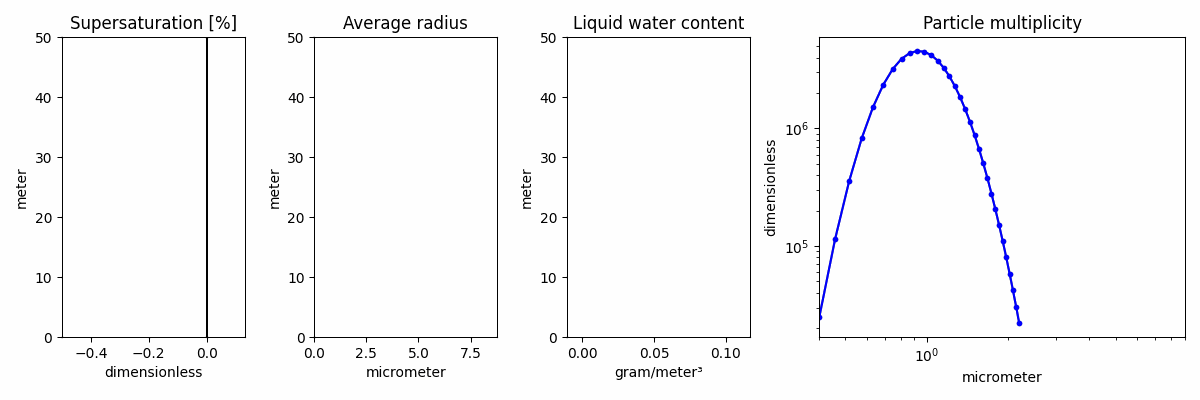

HTML(value="<a href='./tmpo8eviclk.gif' target='_blank'>./tmpo8eviclk.gif</a><br>")

In [13]:
display(progbar := ipywidgets.FloatProgress(max=len(zsteps) - 1))
def plot(frame: int):
    progbar.value = frame
    fig, axs = pyplot.subplot_mosaic(
        mosaic=[["S", "R", "LWC", "spectrum"]],
        gridspec_kw={"width_ratios": [1, 1, 1, 2]},
        figsize=(12, 4),
        tight_layout=True
    )
    
    m_v = system.m_w - numpy.sum(solution.m, axis=0)
    volume = system.m_a / Physics.rho(solution.p, Physics.R_a, solution.T) 

    p_v = m_v / volume * Physics.R_v * solution.T
    p_eq = Physics.p_eq(solution.T)
    supersaturation = 100 * (p_v / p_eq - 1)
    
    axs["S"].plot(supersaturation[:frame], zsteps[:frame])
    axs["S"].vlines(0, ymin=zsteps[0], ymax=zsteps[-1], color='black')
    axs["S"].set(
        xlim=(supersaturation[0], 1.1 * max(supersaturation)),
        ylim=(0, zsteps[-1]),
        title='Supersaturation [%]',
    )
    
    xi_2d = xi.reshape(-1, 1).repeat(zsteps.shape[0], axis=1)
    rads = (solution.m / xi_2d * 3 / 4 / numpy.pi / Physics.rho_w)**(1/3)
    mean_r = numpy.sum(rads * xi_2d, axis=0) / numpy.sum(xi)
    axs["R"].plot(mean_r[:frame], zsteps[:frame])
    axs["R"].xaxis.set_units(si.um)
    axs["R"].set(
        xlim=(0, 1.1 * max(mean_r)), 
        ylim=(0, zsteps[-1]),
        title='Average radius',
    )

    lwc = (system.m_w - m_v) / volume
    axs["LWC"].plot(lwc[:frame], zsteps[:frame])
    axs["LWC"].xaxis.set_units(si.g / si.m**3)
    axs["LWC"].set(
        xlim=(-.1 * max(lwc), 1.1 * max(lwc)),
        ylim=(0, zsteps[-1]),
        title='Liquid water content',
    )

    axs["spectrum"].plot(rads[:, 0], xi, color='gray', marker='.')
    axs["spectrum"].plot(rads[:, frame], xi, color='blue', marker='.')
    axs["spectrum"].xaxis.set_units(si.um)
    axs["spectrum"].yaxis.set_units(si.dimensionless)
    axs["spectrum"].set(
        xlim=(numpy.amin(rads), 1.1*numpy.amax(rads)),
        title='Particle multiplicity',
        xscale='log',
        yscale='log',
    )
    
    return fig
show_anim(plot, frame_range=range(1, len(zsteps)))